In [1]:
import tensorflow as tf 
from tensorflow import keras
import os 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
from scipy import ndimage

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# base_path = 'D:/Dropbox/WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/datasets/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

path = paths[2]
grade = grades[0]
# N_RES = 256

In [3]:
os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg')

'C:/Users/user/Desktop/datasets/Atopy Segmentation\\Intersect_0.85\\Atopy_Segment_Train\\Grade0/*.jpg'

In [4]:
x_train = {}
y_train = {}

x_test = {}
y_test = {}

x_extra = {}
y_extra = {} 


# for path in paths:  
# for grade in grades:
x_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg'))
y_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.png'))

x_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.jpg'))
y_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.png'))

x_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.jpg'))
y_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.png'))

In [5]:
N_RES = 256  
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train_list:
    img = cv2.imread(x)
    # img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img / 255.
    # img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    # lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.imread(y, 0)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # lbl = np.float32(lbl) / 255.
    # lbl = [255 for x in lbl if x > 0]
    lbl[lbl > 0] = 1.
    lbl = np.float32(lbl)
    # lbl = lbl[lbl > 0] = 255
    
    
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])

train_images.shape, train_labels.shape
    

((92, 256, 256, 3), (92, 256, 256, 1))

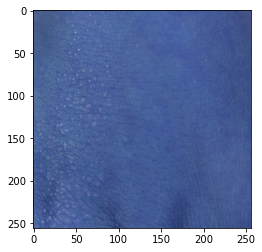

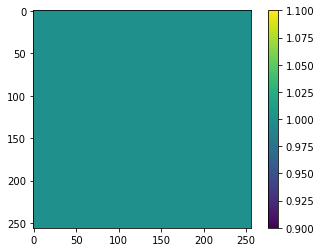

In [6]:
plt.imshow(train_images[0])
plt.show() 

plt.imshow(train_labels[0])
plt.colorbar()
plt.show()

In [7]:
test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test_list:
    img = cv2.imread(x)
    # img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    # img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img / 255.
    # img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    # lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.imread(y, 0)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl[lbl > 0] = 1.
    lbl = np.float32(lbl)
    
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

In [8]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # return pred_mask[0]
    return np.squeeze(pred_mask, axis=0)

from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [9]:
import sys 
sys.path.append('../')
from segmentation_models2 import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()


model = sm.Unet('efficientnetb4', encoder_weights='imagenet', activation='sigmoid', input_shape=(N_RES, N_RES, 3))
preprocess_input = sm.get_preprocessing('efficientnetb4')


Segmentation Models: using `keras` framework.


In [10]:
LR = 0.001
# n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
n_classes = 1


# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', mode='auto', factor=0.2, patience=5, min_lr=0.0001)


model.compile(
    # 'Adam',
    optim, 
    # loss=total_loss,
    # loss='mse', 
    loss=sm.losses.bce_jaccard_loss,
    metrics=metrics,
)


In [11]:

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(train_images, 
                 train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                callbacks=[reduce_lr]
                )

Epoch 1/100
4/4 [==============================] - 14s 873ms/step - loss: 1.2301 - iou_score: 0.4897 - f1-score: 0.6553 - val_loss: 42.0728 - val_iou_score: 0.0110 - val_f1-score: 0.0217 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 315ms/step - loss: 0.9594 - iou_score: 0.7636 - f1-score: 0.8646 - val_loss: 335.3956 - val_iou_score: 0.0055 - val_f1-score: 0.0109 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 1s 306ms/step - loss: 0.7524 - iou_score: 0.9010 - f1-score: 0.9478 - val_loss: 369.2176 - val_iou_score: 1.2135e-04 - val_f1-score: 2.4267e-04 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 1s 302ms/step - loss: 0.6033 - iou_score: 0.9295 - f1-score: 0.9634 - val_loss: 234.5707 - val_iou_score: 1.5214e-04 - val_f1-score: 3.0422e-04 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 1s 306ms/step - loss: 0.4894 - iou_score: 0.9454 - f1-score: 0.9719 - val_loss: 72.0041 - val_iou_score: 6.4851e-04 - val_f1-score: 0

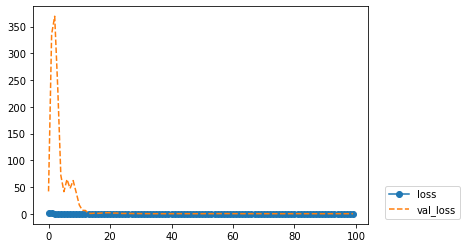

In [12]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.show()

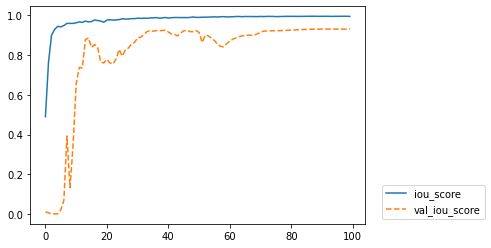

In [13]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
plt.show()
    

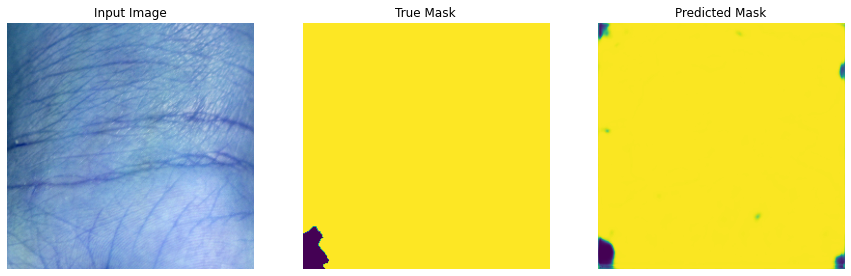

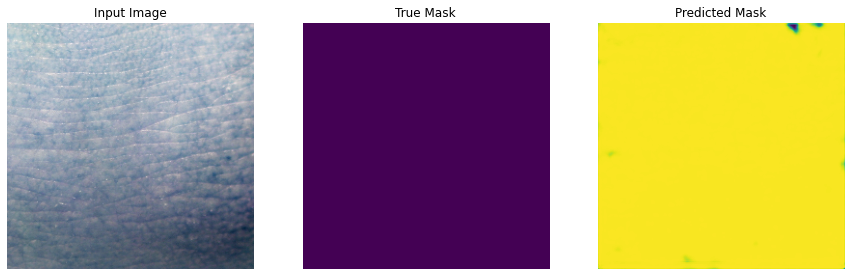

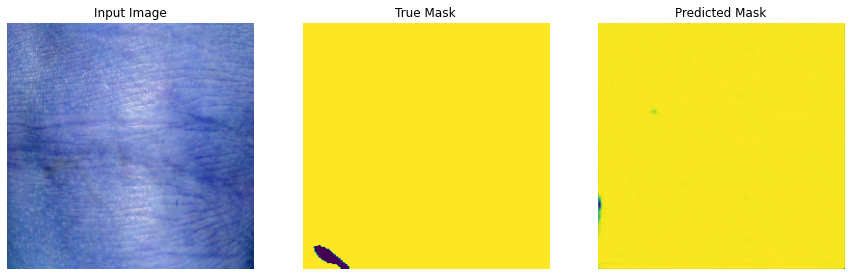

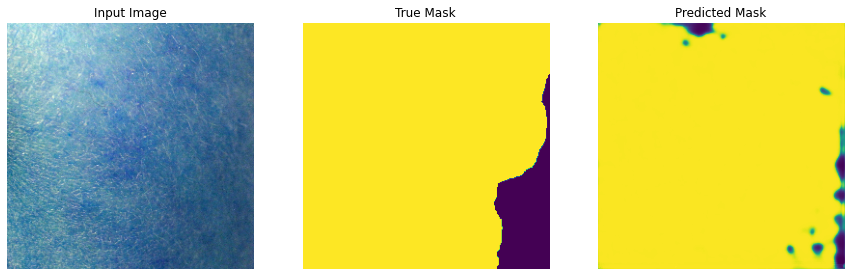

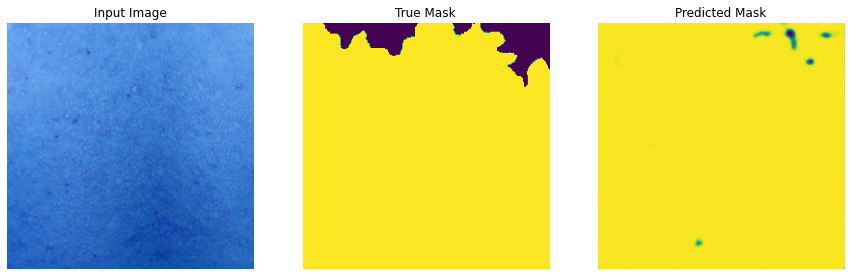

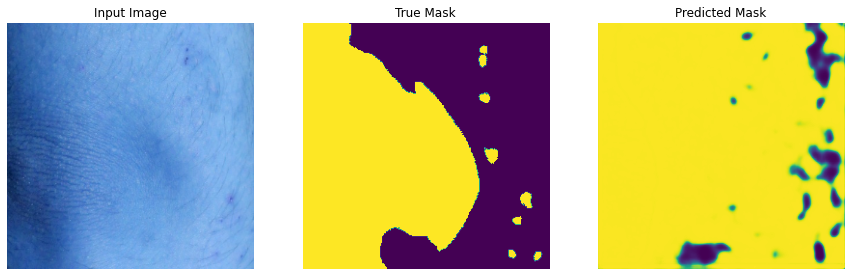

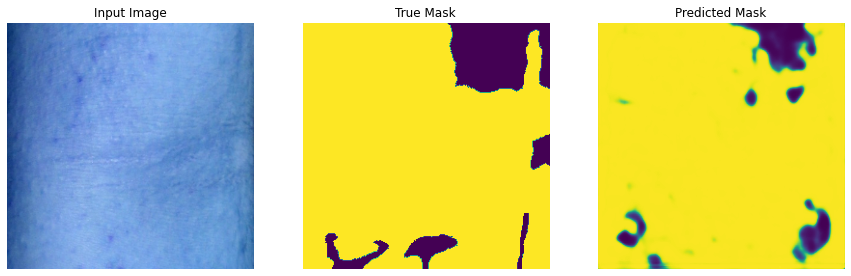

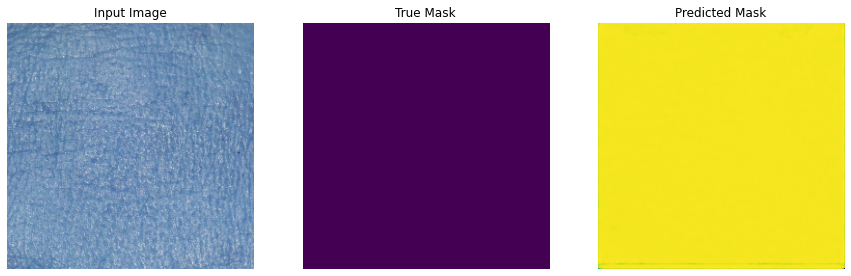

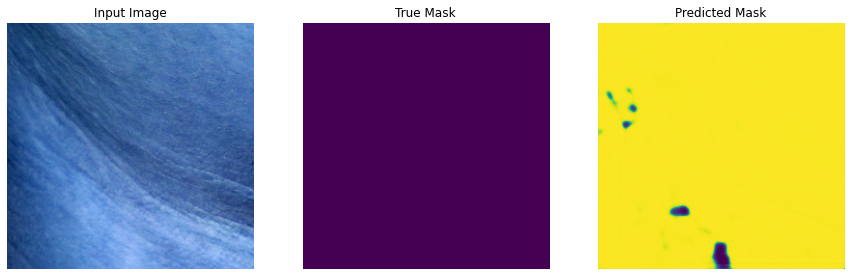

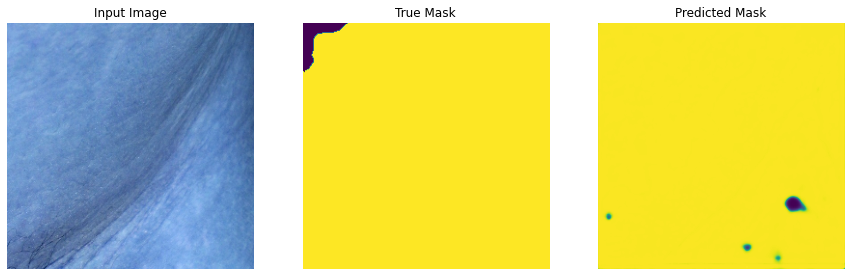

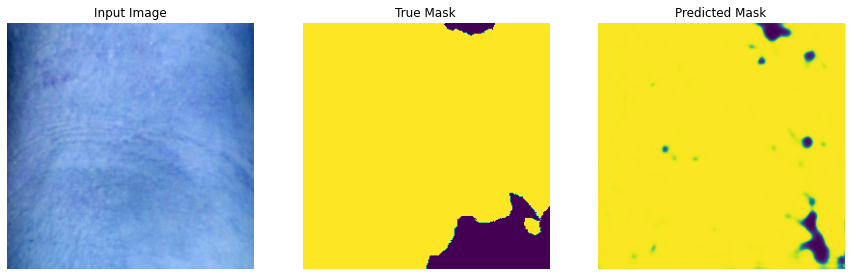

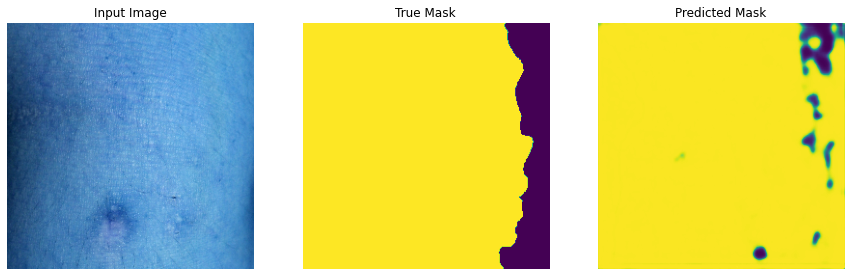

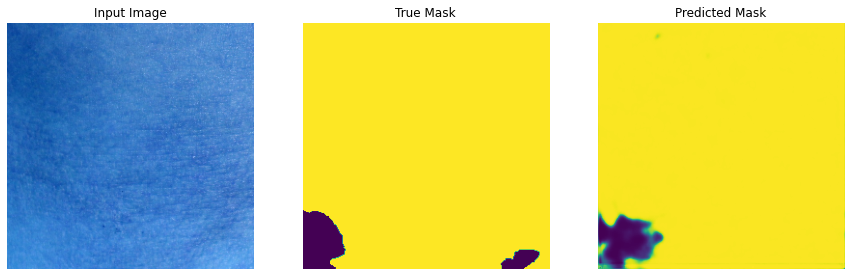

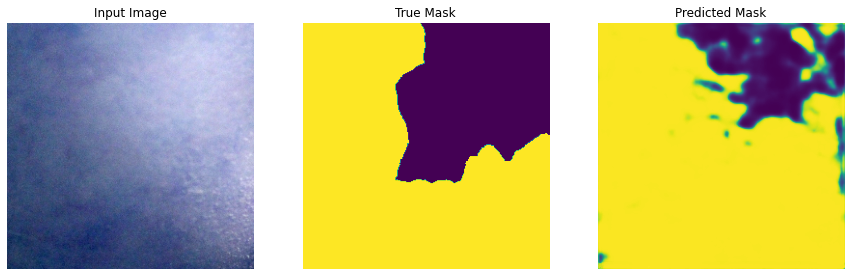

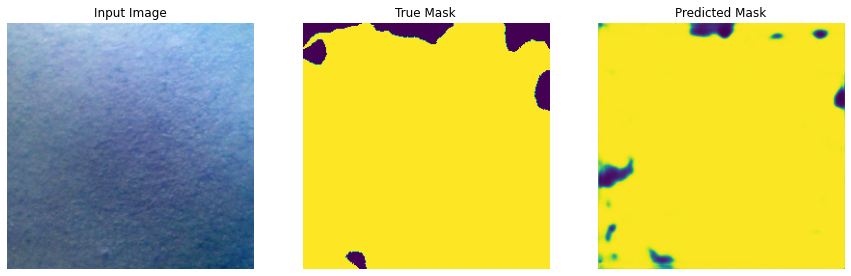

In [14]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model1.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [15]:
train_images.shape

(92, 256, 256, 3)

In [16]:
aug_size = 100 

randidx = np.random.randint(train_images.shape[0], size=aug_size)
# randidx

x_aug = train_images[randidx].copy() 
y_aug = train_labels[randidx].copy() 


In [17]:
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip


aug_train_images = [] 
aug_train_labels = [] 

for x, y in zip(train_images, train_labels):
    
    aug_train_images.append(x)
    aug_train_labels.append(y) 
    
    aug = RandomRotate90(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = HorizontalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])

    aug = VerticalFlip(p=1.0)
    augmented = aug(image=x, mask=y)
    aug_train_images.append(augmented['image'])
    aug_train_labels.append(augmented['mask'])
    
    
aug_train_images = np.reshape(aug_train_images, [-1, N_RES, N_RES, 3]) 
aug_train_labels = np.reshape(aug_train_labels, [-1, N_RES, N_RES, 1]) 

aug_train_images.shape, aug_train_labels.shape

((460, 256, 256, 3), (460, 256, 256, 1))

In [18]:
# random mix up! 
randidx = np.random.randint(aug_train_images.shape[0], size=aug_train_images.shape[0])
# len(randidx)

mix_train_images = [] 
mix_train_labels = []
for idx in randidx:
    # print(idx)
    mix_train_images.append(aug_train_images[idx])
    mix_train_labels.append(aug_train_labels[idx])
    
    
mix_train_images = np.reshape(mix_train_images, [-1, N_RES, N_RES, 3]) 
mix_train_labels = np.reshape(mix_train_labels, [-1, N_RES, N_RES, 1]) 
    
    

In [25]:
hist = model1.fit(mix_train_images, 
                 mix_train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                callbacks=[reduce_lr]
                )

Epoch 1/100


ValueError: in user code:

    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 184, in __call__
        self.build(y_pred)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 133, in build
        self._losses = tf.nest.map_structure(self._get_loss_object, self._losses)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\compile_utils.py", line 272, in _get_loss_object
        loss = losses_mod.get(loss)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\losses.py", line 2374, in get
        raise ValueError(

    ValueError: Could not interpret loss function identifier: <keras.optimizer_v2.adam.Adam object at 0x000001F435FEE610>


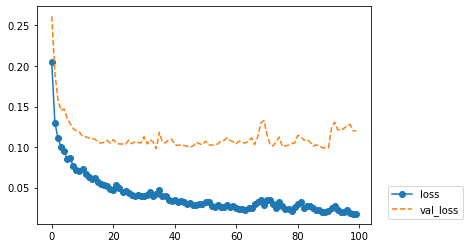

In [20]:
plt.plot(hist.history['loss'], marker='o', label='loss')
plt.plot(hist.history['val_loss'], '--', label='val_loss')
plt.legend(loc=(1.05, 0.02))
plt.show()

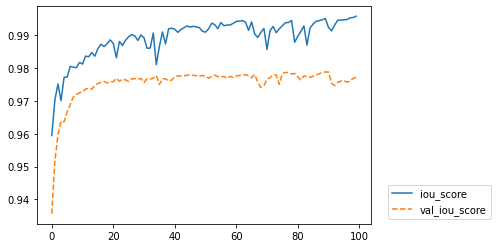

In [21]:
plt.plot(hist.history['iou_score'], label='iou_score')
plt.plot(hist.history['val_iou_score'], '--', label='val_iou_score')
plt.legend(loc=(1.05, 0.02))
plt.show()

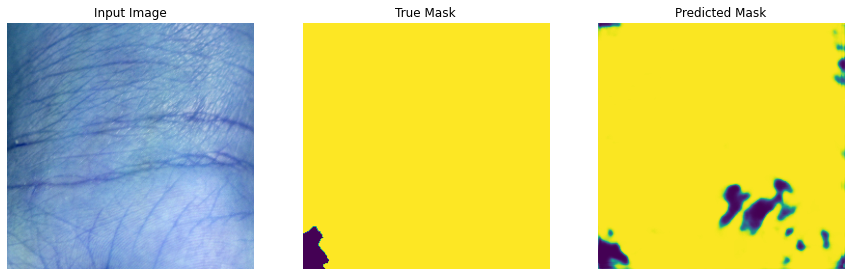

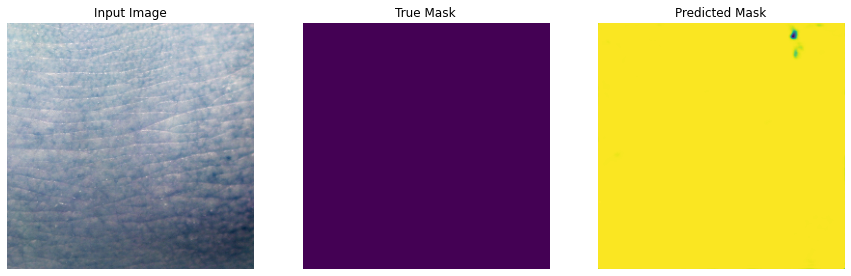

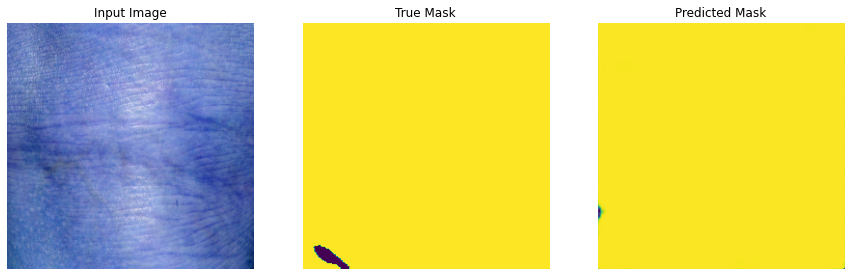

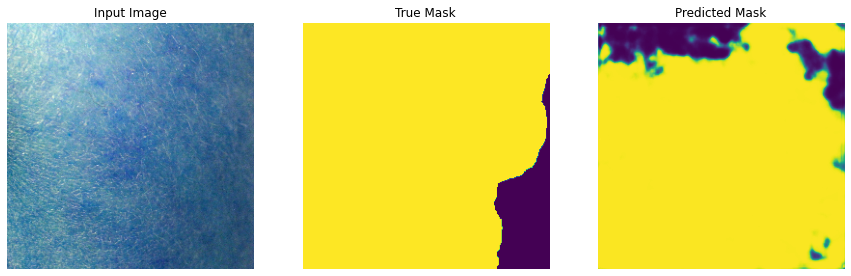

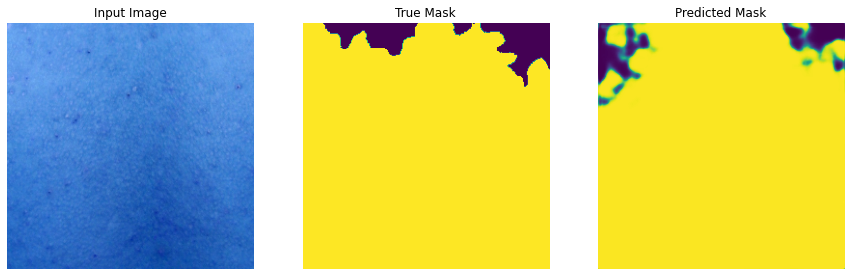

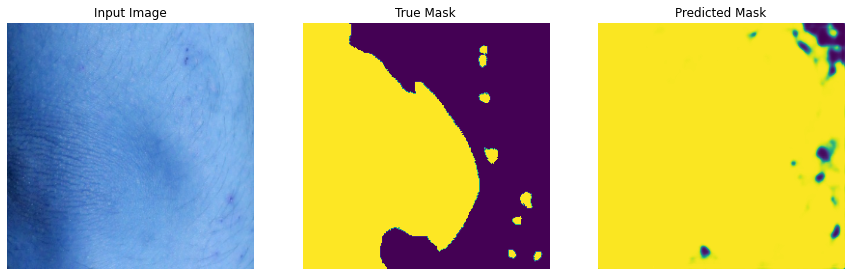

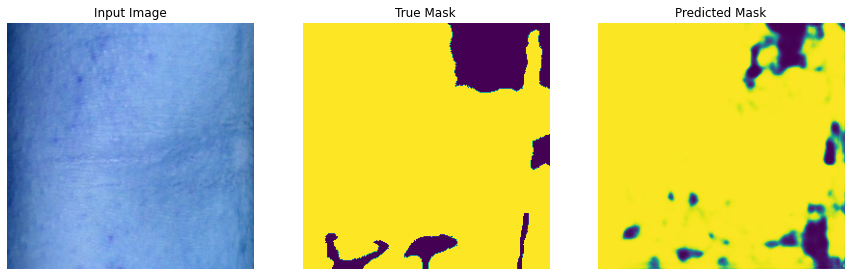

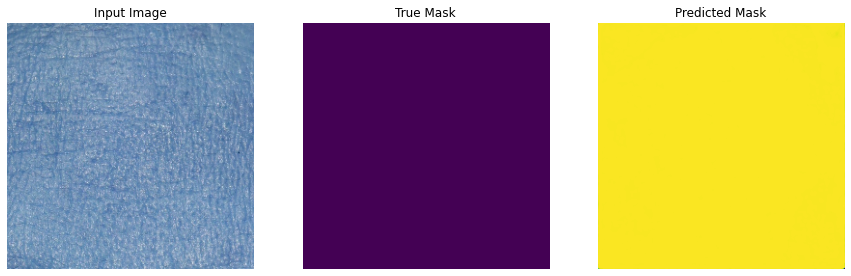

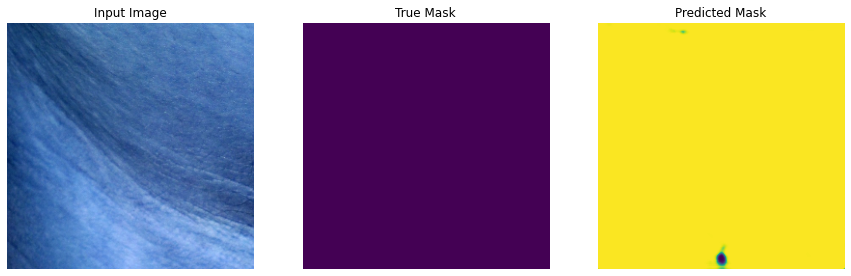

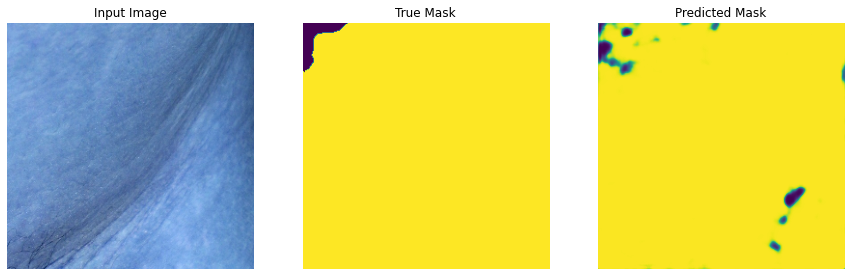

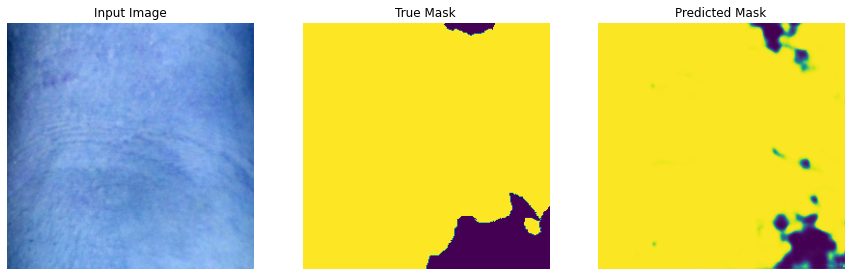

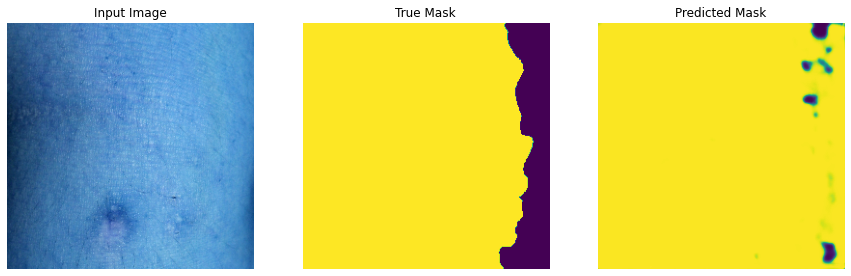

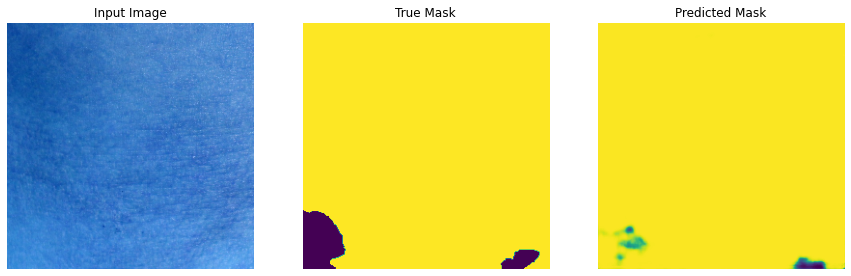

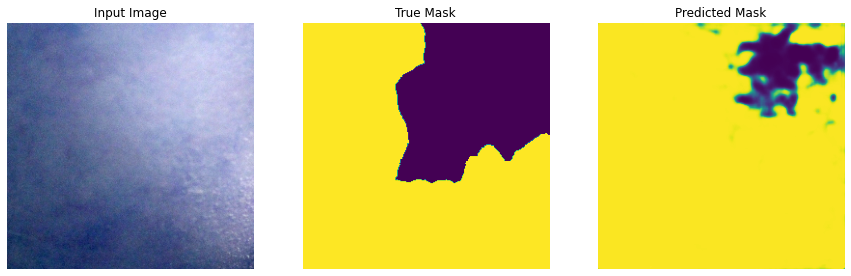

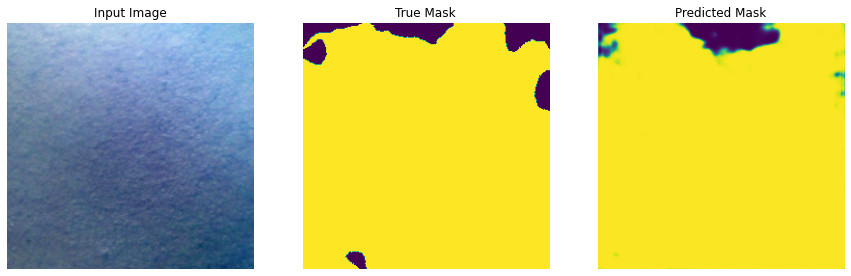

In [22]:
for i in range(0, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model1.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [23]:
import time

model1.save(f'C:/Users/user/Desktop/models/child_segmentation/{time.strftime("%Y%m%d-%H%M%S")}_model.h5')